In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as pg2
import seaborn as sns
from statistics import mean
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge

In [2]:
con_info = {
    'database': 'AnimeDB',
    'user': 'postgres',
    'password': 'password'
}
db_conn = pg2.connect(**con_info)
db_cur = db_conn.cursor()
db_cur.execute("SELECT * FROM animeinfo WHERE rating is not null")
df = pd.DataFrame(db_cur.fetchall())
df.columns = ['anime_id', 'anime_name', 'description', 'rating', 'studio', 'themes', 'categories', 'eps', 'mins_per_epi']
df.set_index('anime_id', inplace=True)
df.head()

,anime_name,description,rating,studio,themes,categories,eps,mins_per_epi
anime_id,,,,,,,,
1,Fullmetal Alchemist: Brotherhood,After a horrific alchemy experiment goes wrong...,9.1,Bones,NULL,"Action, Adventure, Drama, Fantasy",64.0,24
2,Sword Art Online,Ever since the release of the innovative Nerve...,7.2,A-1 Pictures,"Love Polygon, Video Game","Action, Adventure, Fantasy, Romance",25.0,23
3,Naruto,"Moments prior to Naruto Uzumaki's birth, a hug...",7.99,Pierrot,NULL,"Action, Adventure, Fantasy",220.0,23
4,Hunter x Hunter (2011),Hunters devote themselves to accomplishing haz...,9.04,Madhouse,NULL,"Action, Adventure, Fantasy",148.0,23
5,Naruto: Shippuuden,It has been two and a half years since Naruto ...,8.26,Pierrot,NULL,"Action, Adventure, Fantasy",500.0,23


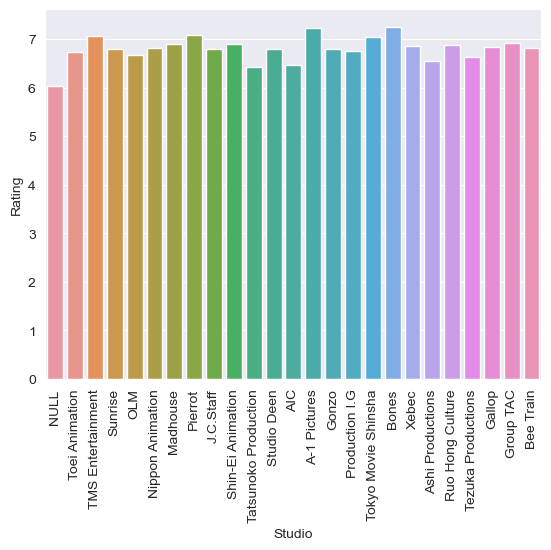

In [3]:
# Studio to rating
temp_df = df.groupby('studio').agg({'studio': 'count', 'rating': 'mean'}).rename(columns={'studio': 'count'}).reset_index()
temp_df = temp_df.sort_values('count', ascending=False).head(25)
sns.barplot(data=temp_df, x='studio', y='rating')
plt.xlabel("Studio")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.show()

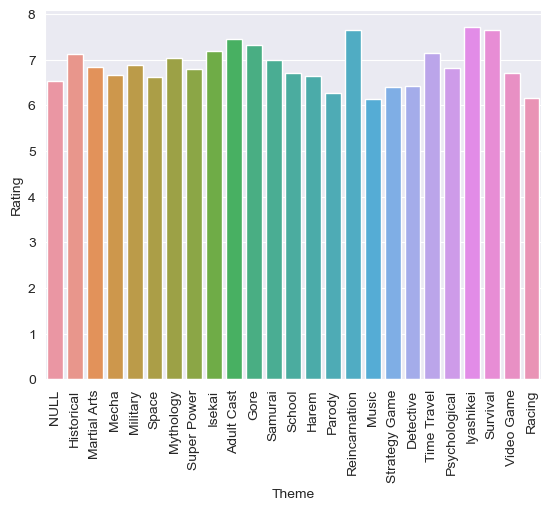

In [4]:
# Themes to rating
themes = {}
temp_df = []
for index, row in df.iterrows():
    anime_themes = row.themes.split(", ")
    for theme in anime_themes:
        if theme in themes:
            themes[theme].append(float(row.rating))
        else:
            themes[theme] = [float(row.rating)]
for key, item in themes.items():
    temp_df.append({'theme': key, 'rating': mean(item), 'count': len(item)})
    
temp_df = pd.DataFrame(temp_df, columns=['theme', 'rating', 'count'])
temp_df = temp_df.sort_values('count', ascending=False).head(25)

sns.barplot(data=temp_df, x='theme', y='rating')
plt.xlabel("Theme")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.show()

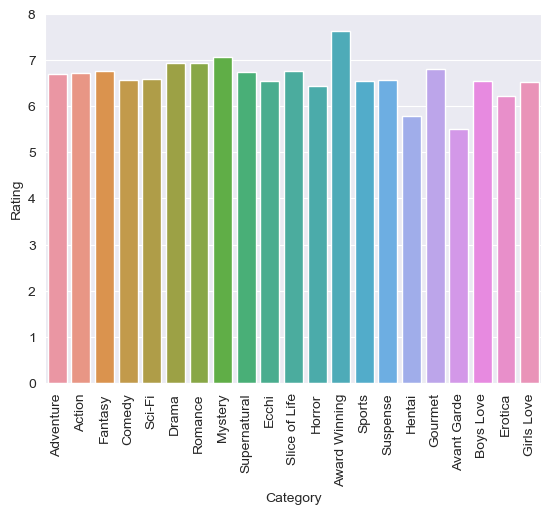

In [5]:
# Categories to rating
categories = {}
temp_df = []
for index, row in df.iterrows():
    anime_categories = row.categories.split(", ")
    for category in anime_categories:
        if category in categories:
            categories[category].append(float(row.rating))
        else:
            categories[category] = [float(row.rating)]
for key, item in categories.items():
    temp_df.append({'category': key, 'rating': mean(item), 'count': len(item)})

temp_df = pd.DataFrame(temp_df, columns=['category', 'rating', 'count'])
temp_df = temp_df.sort_values('count', ascending=False).head(25)

sns.barplot(data=temp_df, x='category', y='rating')
plt.xlabel("Category")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.show()


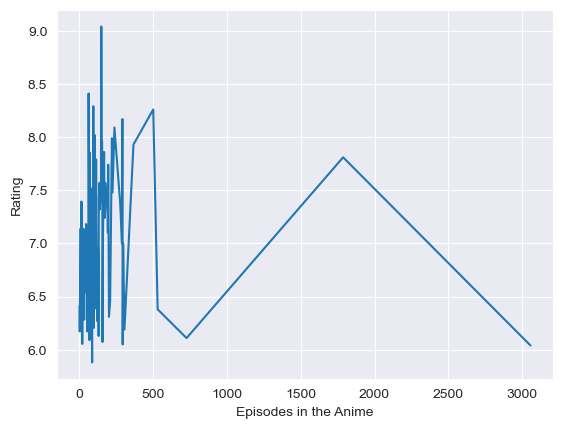

In [6]:
# Number of episodes to rating
temp_df = df.groupby('eps')['rating'].mean().reset_index()
temp_df = temp_df.dropna()
temp_df = temp_df.sort_values('eps')

sns.lineplot(data=temp_df, x='eps', y='rating')
plt.xlabel('Episodes in the Anime')
plt.ylabel('Rating')
plt.show()

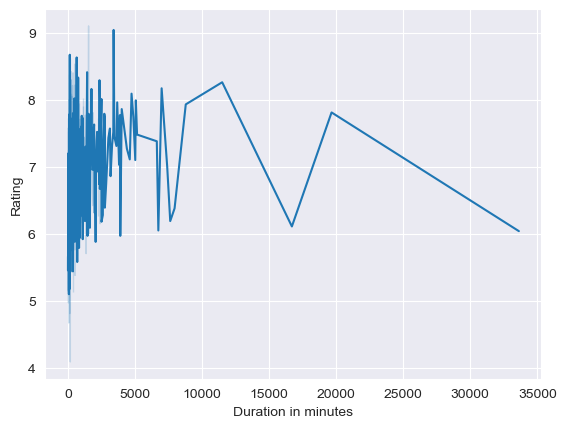

In [7]:
# Length of anime in minutes to rating
temp_df = df[['rating', 'eps', 'mins_per_epi']].copy()
temp_df['duration'] = temp_df['eps'] * temp_df['mins_per_epi']

sns.lineplot(data=temp_df, x='duration', y='rating')
plt.xlabel('Duration in minutes')
plt.ylabel('Rating')
plt.show()

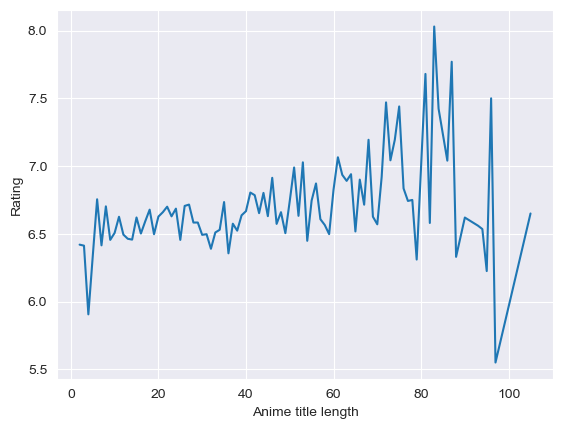

In [8]:
# Length of name to rating
temp_df = df[['anime_name', 'rating']].copy()
temp_df['title_len'] = temp_df['anime_name'].str.len()
temp_df = temp_df.groupby('title_len')['rating'].mean().reset_index()

sns.lineplot(data=temp_df, x='title_len', y='rating')
plt.xlabel('Anime title length')
plt.ylabel('Rating')
plt.show()

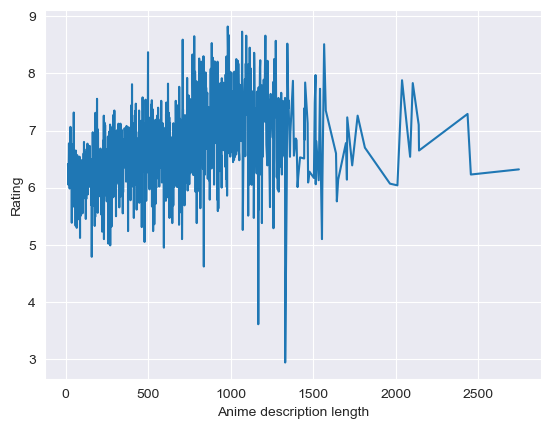

In [9]:
# Length of description to rating
temp_df = df[['description', 'rating']].copy()
temp_df['desc_len'] = temp_df['description'].str.len()
temp_df = temp_df.groupby('desc_len')['rating'].mean().reset_index()

sns.lineplot(data=temp_df, x='desc_len', y='rating')
plt.xlabel('Anime description length')
plt.ylabel('Rating')
plt.show()

In [19]:
# Organizing training dataframe
training_df = df[['studio', 'themes', 'categories', 'eps', 'mins_per_epi', 'rating']].copy()
training_df['name_len'] = df['anime_name'].str.len()
training_df['desc_len'] = df['description'].str.len()

training_df['eps'].fillna(training_df['eps'].mean(), inplace=True)
training_df['mins_per_epi'].fillna(training_df['mins_per_epi'].mean(), inplace=True)
training_df['rating'].dropna(inplace=True)
training_df

,studio,themes,categories,eps,mins_per_epi,rating,name_len,desc_len
anime_id,,,,,,,,
1,Bones,NaN,"Action, Adventure, Drama, Fantasy",64.0,24,9.1,32,1169
2,A-1 Pictures,"Love Polygon, Video Game","Action, Adventure, Fantasy, Romance",25.0,23,7.2,16,1325
3,Pierrot,NaN,"Action, Adventure, Fantasy",220.0,23,7.99,6,677
4,Madhouse,NaN,"Action, Adventure, Fantasy",148.0,23,9.04,22,891
5,Pierrot,NaN,"Action, Adventure, Fantasy",500.0,23,8.26,18,809
...,...,...,...,...,...,...,...,...
5158,NaN,NaN,"Comedy, Drama",1.0,5,5.89,13,377
5161,NaN,NaN,Comedy,1.0,1,5.68,16,124
5209,LICO,"Detective, School","Comedy, Mystery",1.0,1,5.76,23,75


In [28]:
# Splitting and transforming data
continues_df = training_df[['eps', 'mins_per_epi', 'name_len', 'desc_len']]
categorical_df = training_df[['studio', 'themes', 'categories']]

scaler = preprocessing.StandardScaler().fit(continues_df)
continues_transformed = scaler.transform(continues_df)
continues_transformed = pd.DataFrame(continues_transformed)

le = preprocessing.LabelEncoder()
categorical_transformed = categorical_df.apply(le.fit_transform)

continues_transformed.reset_index(drop=True, inplace=True)
categorical_transformed.reset_index(drop=True, inplace=True)
X = pd.concat([continues_transformed, categorical_transformed], axis=1)

X = X.to_numpy()
Y = training_df['rating'].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [30]:
# Creating regression model
RR = Ridge(max_iter=None)
parameters = {
    'alpha': [0.01, 0.1, 1.0],
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'tol': [0.001, 0.01, 0.1],
    'solver': ['auto', 'svd', 'cholesky'],
    'random_state': [None, 3, 5, 32]
}
ridge_cv = GridSearchCV(estimator=RR, param_grid=parameters, scoring='r2', cv=8)
ridge_cv.fit(X_train, Y_train)
print("Best score:", ridge_cv.best_score_)
print("Best parameters:")
ridge_cv.best_params_

Best score: 0.059557935023396444
Best parameters:


{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'random_state': None,
 'solver': 'svd',
 'tol': 0.001}